# Reward Competition Elo Score Calculation

In [1]:
import re
import os
import sys
import string
from collections import defaultdict
import glob
import warnings
from datetime import datetime
from datetime import timedelta
import ast

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xlrd

In [3]:
# setting path
sys.path.append('../../src')

In [4]:
from eloscore import eloscore

In [5]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

## TODO: ADD Summary

# Make it iterate through a list of sheets

- Notebook that calcuates the Elo Score of mice competing over access to a tone associated reward port
- The data is a spreadsheet of combination of subjects (as rows) against dates (as columns)

## Name of protocol for naming

- This name will be used to name files and title plots. Please change if you are using a different protocol or adding more details
    - **NOTE**: This should be changed based on the name the protocol

In [6]:
protocol_name = "reward_competition"

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [7]:
input_folder = "./data"

In [8]:
# Accomodates for both capitalization of the file names
raw_data_file_keyword = '*[rR]eward*'

- Asking the user what the path to the recording files are, with the option of using wildcards

In [9]:
raw_data_glob_pattern = input("""Type out the path(address) of the raw behavioral recording excel sheets.
Remember that if you are using a relative path, it will be based off of the location of this Jupyter Notebook.

Globbing can also be used if you want to search with a wild card(Capitalization matters). 
i.e. './data/*Home*' will be able to find './data/Homecage_observations.xlsx'

NOTE: If left blank, the path will automatically be guessed off of the default settings 
""")

Type out the path(address) of the raw behavioral recording excel sheets.
Remember that if you are using a relative path, it will be based off of the location of this Jupyter Notebook.

Globbing can also be used if you want to search with a wild card(Capitalization matters). 
i.e. './data/*Home*' will be able to find './data/Homecage_observations.xlsx'

NOTE: If left blank, the path will automatically be guessed off of the default settings 
./data/*Reward*


- By default, this will search for files that are in the `./data` folder (in the folder that this notebook is in) that have key word you specified in the file name

In [10]:
# Using the user inputted path/pattern
if raw_data_glob_pattern.strip():
    # Getting a list of all matching files
    raw_data_files_list = glob.glob(raw_data_glob_pattern.strip())
    # Checking if there were any files that matched
    if raw_data_files_list:
        raw_data_file_path = raw_data_files_list[0]
    else:
        raise ValueError("No files were found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))

# Using the default pattern
else:
    # Searching for matching files with recursion
    if glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword)):
        raw_data_glob_pattern = os.path.join(input_folder + "**", raw_data_file_keyword)
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    # Searching for matching files only in the specified folder
    elif glob.glob(os.path.join(input_folder, raw_data_file_keyword)):
        raw_data_glob_pattern = glob.glob(os.path.join(input_folder, raw_data_file_keyword))
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    else:
        raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))


- Checking to see if only one file is specified

In [11]:
if len(raw_data_files_list) >= 2:
    raise ValueError("More than one file was found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))
else:
    # Using the first(and only file) as the file path
    raw_data_file_path = raw_data_files_list[0]

In [12]:
raw_data_file_path

'./data/Reward_Competition_Video_Scoring_Assignments.xlsx'

## Getting a list of all the sheets

In [13]:
# Getting the sheet names for the excel file
xls = pd.ExcelFile(raw_data_file_path)
raw_data_sheet_names = xls.sheet_names

In [14]:
raw_data_sheet_names

['Master Master',
 'Master List',
 'Master Day 2',
 'Master Day 1',
 'Meghan',
 'Jocelyn',
 'Erika',
 'Ezra',
 'Naeliz']

- Asking the user what sheets they want to use

In [15]:
inputted_sheet_names_string = input("""Type out the name of the sheets that you want to be processed. 
Each name must be put in quotes and seperated by a comma(,). i.e. "CAGE3", "CAGE4"

The available sheets are: {}

Alternatively, you can use the index of the list of names above. 
Remember, that Python is zero indexed so the first item will be have the 0 index, second the 1 index, and so on. 
i.e. 1, 2

NOTE: If left blank, all sheets will be used
""".format(raw_data_sheet_names))

Type out the name of the sheets that you want to be processed. 
Each name must be put in quotes and seperated by a comma(,). i.e. "CAGE3", "CAGE4"

The available sheets are: ['Master Master', 'Master List', 'Master Day 2', 'Master Day 1', 'Meghan', 'Jocelyn', 'Erika', 'Ezra', 'Naeliz']

Alternatively, you can use the index of the list of names above. 
Remember, that Python is zero indexed so the first item will be have the 0 index, second the 1 index, and so on. 
i.e. 1, 2

NOTE: If left blank, all sheets will be used
0


In [16]:
# Making a list out of the string of inputted sheet names
if inputted_sheet_names_string:
    inputted_sheet_names_string = "[" + inputted_sheet_names_string + "]"
    # Turning the string into a list
    inputted_sheet_names_list = ast.literal_eval(inputted_sheet_names_string)
# Using all the sheet names if no sheet name is specified
else:
    inputted_sheet_names_list =  raw_data_sheet_names

In [17]:
inputted_sheet_names_list

[0]

- Converting all the numbers into the sheet name that the index of the number corresponds to

In [18]:
for index, sheet in enumerate(inputted_sheet_names_list):
    # Checking if the sheet name was a number
    if isinstance(sheet, int) and str(sheet).isdigit():
        inputted_sheet_names_list[index] =  raw_data_sheet_names[sheet]

In [19]:
inputted_sheet_names_list

['Master Master']

- Checking to see if all the sheets are in the excel file

In [20]:
if not set(inputted_sheet_names_list).issubset(raw_data_sheet_names):
    # Getting all the sheets that were not in the original spreadsheet
    not_included_sheet_names = set(inputted_sheet_names_list) - set(raw_data_sheet_names)
    raise ValueError("All the listed sheet names are not in {}".format(not_included_sheet_names))

## Finding the row for the header

- Headers are the row in a spreadsheet that has all the column names. Sometimes spreadsheets don't use the first row as the row with the column names. So, the row for the header will be asked or assumed to be the first row

In [21]:
sheet_name_to_everything = defaultdict(dict)
for sheet in inputted_sheet_names_list:
    print("\nCurrent Sheet Name: {}".format(sheet))    
    per_sheet_dataframe = pd.read_excel(raw_data_file_path, sheet_name=sheet, header=0)
    
    # Showing the columns that are chosen with the header being the 0th row
    print("Columns Names: {}".format(per_sheet_dataframe.columns))
    # Show the dataframe that would be created with the header being the 0th row
    print("First few rows of this dataframe:")
    print(pd.read_excel(raw_data_file_path, sheet_name=sheet, header=0).head())
    
    # Allowing the user the choose the row number for the header
    header_row = input("""Type the row number to be used as the header
    (AKA the row with the column name that you want to use.)
    If you want to keep the column names that were displayed, type 0.
    If you want to use a different row, then type the corresponding number. 
    
    The rows displayed in this cell are dataframes created from Pandas. 
    To use the row with the 0 index for column names, type 1. 
    For the row with the 1 index, it will be 2 and so on. i.e. 2
    
    If you are looking at the original spread sheet, remember that Python is zero indexed. 
    So the first row will be 0, second will be 1, and so on. 
    i.e. 1
    
    NOTE: If left blank, the original row that was used will be used.
    """).strip()
    
    if header_row == "":
        header_row = 0
    else:
        header_row = int(header_row)
    
    # Checking if any of the column names are from empty cells
    column_names = "".join([str(col) for col in pd.read_excel(raw_data_file_path, sheet_name=sheet, header=header_row).columns])
    # If a column name came from an empty cell, it would have "Unnamed" in it
    if "Unnamed" in column_names:
        raise ValueError("""Not all the cells in the chosen row are filled in.
                         Please choose a row that has the name of the columns
                         
                         The values in this row are: {}""".format(column_names))
    else:
        sheet_name_to_everything[sheet]["header_row"] = header_row


Current Sheet Name: Master Master
Columns Names: Index(['Date', 'Cage', 'Box', 'Match', 'Scorer', 'Trial 1 Time',
       'Trial 1 Winner', 'Trial 2 Time ', 'Trial 2 Winner', 'Trial 3 Time',
       'Trial 3 Winner', 'Trial 4 Time', 'Trial 4 Winner', 'Trial 5 Time',
       'Trial 5 Winner', 'Trial 6 Time', 'Trial 6 Winner', 'Trial 7 Time',
       'Trial 7 Winner', 'Trial 8 Time', 'Trial 8 Winner', 'Trial 9 Time',
       'Trial 9 Winner', 'Trial 10 Time ', 'Trial 10 Winner', 'Trial 11 Time',
       'Trial 11 Winner', 'Trial 12 Time ', 'Trial 12 Winner', 'Trial 13 Time',
       'Trial 13 Winner', 'Trial 14 Time', 'Trial 14 Winner', 'Trial 15 Time',
       'Trial 15 Winner', 'Trial 16 Time ', 'Trial 16 Winner', 'Trial 17 Time',
       'Trial 17 Winner', 'Trial 18 Time', 'Trial 18 Winner', 'Trial 19 Time',
       'Trial 19 Winner', 'Trial 20 Time', 'Trial 20 Winner', 'Mouse 1 Wins',
       'Mouse 2 Wins', 'Ties '],
      dtype='object')
First few rows of this dataframe:
        Date  Cage  

In [22]:
sheet_name_to_everything

defaultdict(dict, {'Master Master': {'header_row': 0}})

## Reading in all the spreadsheets

In [23]:
# Going through each sheet and creating a dataframe of it
for key, value in sheet_name_to_everything.items():
    sheet_name_to_everything[key]["original_behavior_recording_dataframe"] = pd.read_excel(raw_data_file_path, sheet_name=key, header=value["header_row"])

In [24]:
sheet_name_to_everything[key]["original_behavior_recording_dataframe"].head()

,Date,Cage,Box,Match,Scorer,Trial 1 Time,Trial 1 Winner,Trial 2 Time,Trial 2 Winner,Trial 3 Time,...,Trial 17 Winner,Trial 18 Time,Trial 18 Winner,Trial 19 Time,Trial 19 Winner,Trial 20 Time,Trial 20 Winner,Mouse 1 Wins,Mouse 2 Wins,Ties
0,2022-05-19,1,1.0,1.1 v 2.2,NaN,1:12-1:22,1.1,2:31-2:41,1.1,4:00-4:10,...,1.1,27:00-27:10,2.2,28:19-28:29,1.1,29:53-30:03,1.1,11.0,9,0.0
1,2022-05-19,1,2.0,2.3 v 1.4,NaN,1:12-1:22,1.4,2:30-2:40,1.4,3:59-4:09,...,1.4,27:01-27:11,1.4,28:20-28:30,2.3,29:53-30:03,2.3,11.0,9,0.0
2,2022-05-19,1,3.0,1.1 v 2.3,NaN,1:07-1:17,2.3,3:56-4:06,tie,5:14-5:24,...,2.3,28:16-28:26,2.3,29:49-29:59,2.3,NaN,NaN,NaN,NaN,NaN
3,2022-05-19,1,4.0,2.2 v 1.4,NaN,1:06-1:16,1.4,2:25-2:35,2.2,3:54-4:04,...,2.2,26:56-27:06,1.4,28:15-28:25,1.4,29:48-29:58,1.4,NaN,checked whole row,NaN
4,2022-05-19,1,2.0,2.2 v 2.3,NaN,1:11-1:21,2.2,2:30-2:40,2.3,4:00-4:10,...,2.3,27:01-27:11,2.2,28:19-28:29,2.2,29:53-30:03,2.2,NaN,checked whole row,NaN


In [25]:
sheet_name_to_everything[key]["original_behavior_recording_dataframe"].tail()

,Date,Cage,Box,Match,Scorer,Trial 1 Time,Trial 1 Winner,Trial 2 Time,Trial 2 Winner,Trial 3 Time,...,Trial 17 Winner,Trial 18 Time,Trial 18 Winner,Trial 19 Time,Trial 19 Winner,Trial 20 Time,Trial 20 Winner,Mouse 1 Wins,Mouse 2 Wins,Ties
43,2022-05-20,4,1.0,3.4 (2) v 4.3 (3),NaN,1:13-1:23,4.3 (3),2:31-2:41,4.3 (3),4:00-4:10,...,4.3 (3),27:01-27:11,4.3 (3),28:20-28:30,4.3 (3),29:54-30:04,3.4 (2),6.0,10,4.0
44,2022-05-20,4,4.0,3.1 (1) v 4.3 (3),NaN,2:56-3:06,4.3 (3),4:15-4:25,4.3 (3),5:44-5:54,...,3.1 (1),28:46-28:56,3.1 (1),30:05-30:15,3.1 (1),NaN,NaN,13.0,5,1.0
45,2022-05-20,4,3.0,3.4 (2) v 4.4 (4),NaN,2:57-3:07,4.4 (4),4:15-4:25,4.4 (4),5:44-5:54,...,3.4 (2),28:46-28:56,4.4 (4),30:05-30:15,3.4 (2),NaN,NaN,NaN,checked whole row,NaN
46,2022-05-20,4,2.0,3.1 (1) v 3.4 (2),NaN,1:11-1:21,3.1 (1),2:30-2:40,3.4 (2),3:58-4:08,...,3.1 (1),27:00-27:10,3.1 (1),28:19-28:29,3.1 (1),29:52-30:02,3.1 (1),NaN,checked whole row,NaN
47,2022-05-20,4,1.0,4.3 (3) v 4.4 (4),NaN,1:12-1:22,4.3 (3),2:30-2:40,4.3 (3),3:58-4:08,...,4.4 (4),27:00-27:10,Tie,28:19-28:29,4.4 (4),29:53-30:03,4.3 (3),7.0,12,1.0


## Standarizing the Columns

- Making all the column names lower case and removing any extra spaces in the beginning and at the end

In [26]:
for key, value in sheet_name_to_everything.items():
    # Creating a dictionary that maps the original column name to the standarized one
    column_name_to_standarized = defaultdict(dict)
    for col in sheet_name_to_everything[key]["original_behavior_recording_dataframe"]:
        # Making the column name lower case and removing the spaces
        column_name_to_standarized[col] = str(col).lower().strip()
    sheet_name_to_everything[key]["column_name_to_standarized"] = column_name_to_standarized

In [27]:
sheet_name_to_everything[key]["column_name_to_standarized"]

defaultdict(dict,
            {'Date': 'date',
             'Cage': 'cage',
             'Box': 'box',
             'Match': 'match',
             'Scorer': 'scorer',
             'Trial 1 Time': 'trial 1 time',
             'Trial 1 Winner': 'trial 1 winner',
             'Trial 2 Time ': 'trial 2 time',
             'Trial 2 Winner': 'trial 2 winner',
             'Trial 3 Time': 'trial 3 time',
             'Trial 3 Winner': 'trial 3 winner',
             'Trial 4 Time': 'trial 4 time',
             'Trial 4 Winner': 'trial 4 winner',
             'Trial 5 Time': 'trial 5 time',
             'Trial 5 Winner': 'trial 5 winner',
             'Trial 6 Time': 'trial 6 time',
             'Trial 6 Winner': 'trial 6 winner',
             'Trial 7 Time': 'trial 7 time',
             'Trial 7 Winner': 'trial 7 winner',
             'Trial 8 Time': 'trial 8 time',
             'Trial 8 Winner': 'trial 8 winner',
             'Trial 9 Time': 'trial 9 time',
             'Trial 9 Winner': 'tri

In [28]:
# Renaming all the columns to the lower case and space removed version
for key, value in sheet_name_to_everything.items():
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"] = sheet_name_to_everything[key]["original_behavior_recording_dataframe"].rename(columns=sheet_name_to_everything[key]["column_name_to_standarized"])

In [29]:
sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].head()

,date,cage,box,match,scorer,trial 1 time,trial 1 winner,trial 2 time,trial 2 winner,trial 3 time,...,trial 17 winner,trial 18 time,trial 18 winner,trial 19 time,trial 19 winner,trial 20 time,trial 20 winner,mouse 1 wins,mouse 2 wins,ties
0,2022-05-19,1,1.0,1.1 v 2.2,NaN,1:12-1:22,1.1,2:31-2:41,1.1,4:00-4:10,...,1.1,27:00-27:10,2.2,28:19-28:29,1.1,29:53-30:03,1.1,11.0,9,0.0
1,2022-05-19,1,2.0,2.3 v 1.4,NaN,1:12-1:22,1.4,2:30-2:40,1.4,3:59-4:09,...,1.4,27:01-27:11,1.4,28:20-28:30,2.3,29:53-30:03,2.3,11.0,9,0.0
2,2022-05-19,1,3.0,1.1 v 2.3,NaN,1:07-1:17,2.3,3:56-4:06,tie,5:14-5:24,...,2.3,28:16-28:26,2.3,29:49-29:59,2.3,NaN,NaN,NaN,NaN,NaN
3,2022-05-19,1,4.0,2.2 v 1.4,NaN,1:06-1:16,1.4,2:25-2:35,2.2,3:54-4:04,...,2.2,26:56-27:06,1.4,28:15-28:25,1.4,29:48-29:58,1.4,NaN,checked whole row,NaN
4,2022-05-19,1,2.0,2.2 v 2.3,NaN,1:11-1:21,2.2,2:30-2:40,2.3,4:00-4:10,...,2.3,27:01-27:11,2.2,28:19-28:29,2.2,29:53-30:03,2.2,NaN,checked whole row,NaN


## Removing Unnecessary Columns

# TODO: Pick which columns to drop or keep

In [30]:
reward_competition_df = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"]

In [31]:
reward_competition_df.columns

Index(['date', 'cage', 'box', 'match', 'scorer', 'trial 1 time',
       'trial 1 winner', 'trial 2 time', 'trial 2 winner', 'trial 3 time',
       'trial 3 winner', 'trial 4 time', 'trial 4 winner', 'trial 5 time',
       'trial 5 winner', 'trial 6 time', 'trial 6 winner', 'trial 7 time',
       'trial 7 winner', 'trial 8 time', 'trial 8 winner', 'trial 9 time',
       'trial 9 winner', 'trial 10 time', 'trial 10 winner', 'trial 11 time',
       'trial 11 winner', 'trial 12 time', 'trial 12 winner', 'trial 13 time',
       'trial 13 winner', 'trial 14 time', 'trial 14 winner', 'trial 15 time',
       'trial 15 winner', 'trial 16 time', 'trial 16 winner', 'trial 17 time',
       'trial 17 winner', 'trial 18 time', 'trial 18 winner', 'trial 19 time',
       'trial 19 winner', 'trial 20 time', 'trial 20 winner', 'mouse 1 wins',
       'mouse 2 wins', 'ties'],
      dtype='object')

In [32]:
reward_competition_df = reward_competition_df.drop(["mouse 1 wins", "mouse 2 wins", "ties", " "], axis=1, errors="ignore")

In [33]:
columns_to_keep = [col for col in reward_competition_df.columns if "time" not in col.lower().strip()]

In [34]:
columns_to_keep

['date',
 'cage',
 'box',
 'match',
 'scorer',
 'trial 1 winner',
 'trial 2 winner',
 'trial 3 winner',
 'trial 4 winner',
 'trial 5 winner',
 'trial 6 winner',
 'trial 7 winner',
 'trial 8 winner',
 'trial 9 winner',
 'trial 10 winner',
 'trial 11 winner',
 'trial 12 winner',
 'trial 13 winner',
 'trial 14 winner',
 'trial 15 winner',
 'trial 16 winner',
 'trial 17 winner',
 'trial 18 winner',
 'trial 19 winner',
 'trial 20 winner']

In [35]:
reward_competition_df = reward_competition_df[columns_to_keep].copy()

In [36]:
reward_competition_df.head()

,date,cage,box,match,scorer,trial 1 winner,trial 2 winner,trial 3 winner,trial 4 winner,trial 5 winner,...,trial 11 winner,trial 12 winner,trial 13 winner,trial 14 winner,trial 15 winner,trial 16 winner,trial 17 winner,trial 18 winner,trial 19 winner,trial 20 winner
0,2022-05-19,1,1.0,1.1 v 2.2,NaN,1.1,1.1,1.1,1.1,2.2,...,1.1,2.2,2.2,2.2,2.2,2.2,1.1,2.2,1.1,1.1
1,2022-05-19,1,2.0,2.3 v 1.4,NaN,1.4,1.4,2.3,2.3,1.4,...,2.3,2.3,2.3,2.3,1.4,1.4,1.4,1.4,2.3,2.3
2,2022-05-19,1,3.0,1.1 v 2.3,NaN,2.3,tie,2.3,1.1,1.1,...,2.3,2.3,1.1,2.3,2.3,2.3,2.3,2.3,2.3,NaN
3,2022-05-19,1,4.0,2.2 v 1.4,NaN,1.4,2.2,2.2,2.2,1.4,...,2.2,1.4,2.2,2.2,1.4,2.2,2.2,1.4,1.4,1.4
4,2022-05-19,1,2.0,2.2 v 2.3,NaN,2.2,2.3,2.3,2.3,2.2,...,2.3,tie,2.2,2.3,2.2,2.2,2.3,2.2,2.2,2.2


In [37]:
reward_competition_df = reward_competition_df.dropna(subset=["trial 1 winner"])

## Add both IDs as a column

# TODO: Pick the match column

In [38]:
reward_competition_df["animal_ids"] = reward_competition_df["match"].apply(lambda x: set([x.strip() for x in x.split("v")]))

In [39]:
reward_competition_df.head()

,date,cage,box,match,scorer,trial 1 winner,trial 2 winner,trial 3 winner,trial 4 winner,trial 5 winner,...,trial 12 winner,trial 13 winner,trial 14 winner,trial 15 winner,trial 16 winner,trial 17 winner,trial 18 winner,trial 19 winner,trial 20 winner,animal_ids
0,2022-05-19,1,1.0,1.1 v 2.2,NaN,1.1,1.1,1.1,1.1,2.2,...,2.2,2.2,2.2,2.2,2.2,1.1,2.2,1.1,1.1,"{1.1, 2.2}"
1,2022-05-19,1,2.0,2.3 v 1.4,NaN,1.4,1.4,2.3,2.3,1.4,...,2.3,2.3,2.3,1.4,1.4,1.4,1.4,2.3,2.3,"{1.4, 2.3}"
2,2022-05-19,1,3.0,1.1 v 2.3,NaN,2.3,tie,2.3,1.1,1.1,...,2.3,1.1,2.3,2.3,2.3,2.3,2.3,2.3,NaN,"{1.1, 2.3}"
3,2022-05-19,1,4.0,2.2 v 1.4,NaN,1.4,2.2,2.2,2.2,1.4,...,1.4,2.2,2.2,1.4,2.2,2.2,1.4,1.4,1.4,"{1.4, 2.2}"
4,2022-05-19,1,2.0,2.2 v 2.3,NaN,2.2,2.3,2.3,2.3,2.2,...,tie,2.2,2.3,2.2,2.2,2.3,2.2,2.2,2.2,"{2.3, 2.2}"


## Melt 

In [40]:
reward_competition_df["index"] = reward_competition_df.index
reward_competition_df = reward_competition_df.reset_index(drop=True)

In [41]:
reward_competition_df.head()

,date,cage,box,match,scorer,trial 1 winner,trial 2 winner,trial 3 winner,trial 4 winner,trial 5 winner,...,trial 13 winner,trial 14 winner,trial 15 winner,trial 16 winner,trial 17 winner,trial 18 winner,trial 19 winner,trial 20 winner,animal_ids,index
0,2022-05-19,1,1.0,1.1 v 2.2,NaN,1.1,1.1,1.1,1.1,2.2,...,2.2,2.2,2.2,2.2,1.1,2.2,1.1,1.1,"{1.1, 2.2}",0
1,2022-05-19,1,2.0,2.3 v 1.4,NaN,1.4,1.4,2.3,2.3,1.4,...,2.3,2.3,1.4,1.4,1.4,1.4,2.3,2.3,"{1.4, 2.3}",1
2,2022-05-19,1,3.0,1.1 v 2.3,NaN,2.3,tie,2.3,1.1,1.1,...,1.1,2.3,2.3,2.3,2.3,2.3,2.3,NaN,"{1.1, 2.3}",2
3,2022-05-19,1,4.0,2.2 v 1.4,NaN,1.4,2.2,2.2,2.2,1.4,...,2.2,2.2,1.4,2.2,2.2,1.4,1.4,1.4,"{1.4, 2.2}",3
4,2022-05-19,1,2.0,2.2 v 2.3,NaN,2.2,2.3,2.3,2.3,2.2,...,2.2,2.3,2.2,2.2,2.3,2.2,2.2,2.2,"{2.3, 2.2}",4


# TODO: Pick the columns to keep

In [42]:
melted_reward_competition_df = reward_competition_df.melt(id_vars=["index", "date", "cage", "box", "match", "scorer", "animal_ids"], 
        var_name="trial", 
        value_name="winner")

In [43]:
melted_reward_competition_df.head()

,index,date,cage,box,match,scorer,animal_ids,trial,winner
0,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 1 winner,1.1
1,1,2022-05-19,1,2.0,2.3 v 1.4,NaN,"{1.4, 2.3}",trial 1 winner,1.4
2,2,2022-05-19,1,3.0,1.1 v 2.3,NaN,"{1.1, 2.3}",trial 1 winner,2.3
3,3,2022-05-19,1,4.0,2.2 v 1.4,NaN,"{1.4, 2.2}",trial 1 winner,1.4
4,4,2022-05-19,1,2.0,2.2 v 2.3,NaN,"{2.3, 2.2}",trial 1 winner,2.2


- Dropping all rows that don't contain Winner

In [44]:
melted_reward_competition_df = melted_reward_competition_df.dropna(subset="winner")

- Making all the ids into string

In [45]:
melted_reward_competition_df["winner"] = melted_reward_competition_df["winner"].astype(str)

- Getting the number of the trial so that we can order by number(instead of string, which would make 11 come before 2)

In [46]:
melted_reward_competition_df["trial_number"] = melted_reward_competition_df["trial"].apply(lambda x: int(x.lower().strip("trial").strip("winner")))

In [47]:
melted_reward_competition_df = melted_reward_competition_df.sort_values(["index", "trial_number"])

In [48]:
melted_reward_competition_df.head()

,index,date,cage,box,match,scorer,animal_ids,trial,winner,trial_number
0,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 1 winner,1.1,1
48,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 2 winner,1.1,2
96,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 3 winner,1.1,3
144,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 4 winner,1.1,4
192,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 5 winner,2.2,5


In [49]:
melted_reward_competition_df["trial_number"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [50]:
melted_reward_competition_df["winner"].unique()

array(['1.1', '2.2', '1.4', '2.3', 'tie', 'Tie', 'NO TRIAL', '2.1', '1.2',
       '1.3', '2.4', '4.1 (1)', '3.2 (2)', '4.2 (3)', '3.3 (4)',
       '3.1 (1)', '3.4 (2)', '4.3 (3)', '4.4 (4)'], dtype=object)

- Removing all the ties

In [51]:
all_winner_ids = []
for winner_id in melted_reward_competition_df["winner"].unique():
    if not re.search('[a-zA-Z]', str(winner_id)):
        all_winner_ids.append(winner_id)

In [52]:
all_winner_ids

['1.1',
 '2.2',
 '1.4',
 '2.3',
 '2.1',
 '1.2',
 '1.3',
 '2.4',
 '4.1 (1)',
 '3.2 (2)',
 '4.2 (3)',
 '3.3 (4)',
 '3.1 (1)',
 '3.4 (2)',
 '4.3 (3)',
 '4.4 (4)']

- Dropping all rows that don't have numbers as IDs for the winner column

In [53]:
melted_reward_competition_df = melted_reward_competition_df[melted_reward_competition_df["winner"].isin(all_winner_ids)]

In [54]:
melted_reward_competition_df["winner"].unique()

array(['1.1', '2.2', '1.4', '2.3', '2.1', '1.2', '1.3', '2.4', '4.1 (1)',
       '3.2 (2)', '4.2 (3)', '3.3 (4)', '3.1 (1)', '3.4 (2)', '4.3 (3)',
       '4.4 (4)'], dtype=object)

## Add a column for the loser ID

In [55]:
melted_reward_competition_df.columns

Index(['index', 'date', 'cage', 'box', 'match', 'scorer', 'animal_ids',
       'trial', 'winner', 'trial_number'],
      dtype='object')

In [56]:
melted_reward_competition_df.head()

,index,date,cage,box,match,scorer,animal_ids,trial,winner,trial_number
0,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 1 winner,1.1,1
48,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 2 winner,1.1,2
96,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 3 winner,1.1,3
144,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 4 winner,1.1,4
192,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 5 winner,2.2,5


In [57]:
melted_reward_competition_df["loser"] = melted_reward_competition_df.apply(lambda x: (list(x["animal_ids"] - set([x["winner"]]))[0]), axis=1)

In [58]:
melted_reward_competition_df["loser"].unique()

array(['2.2', '1.1', '2.3', '1.4', '1.2', '2.1', '2.4', '1.3', '3.2 (2)',
       '4.1 (1)', '3.3 (4)', '4.2 (3)', '3.4 (2)', '3.1 (1)', '4.4 (4)',
       '4.3 (3)'], dtype=object)

In [59]:
melted_reward_competition_df.head(n=5)

,index,date,cage,box,match,scorer,animal_ids,trial,winner,trial_number,loser
0,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 1 winner,1.1,1,2.2
48,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 2 winner,1.1,2,2.2
96,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 3 winner,1.1,3,2.2
144,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 4 winner,1.1,4,2.2
192,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 5 winner,2.2,5,1.1


In [60]:
melted_reward_competition_df.tail(n=5)

,index,date,cage,box,match,scorer,animal_ids,trial,winner,trial_number,loser
719,47,2022-05-20,4,1.0,4.3 (3) v 4.4 (4),NaN,"{4.4 (4), 4.3 (3)}",trial 15 winner,4.3 (3),15,4.4 (4)
767,47,2022-05-20,4,1.0,4.3 (3) v 4.4 (4),NaN,"{4.4 (4), 4.3 (3)}",trial 16 winner,4.3 (3),16,4.4 (4)
815,47,2022-05-20,4,1.0,4.3 (3) v 4.4 (4),NaN,"{4.4 (4), 4.3 (3)}",trial 17 winner,4.4 (4),17,4.3 (3)
911,47,2022-05-20,4,1.0,4.3 (3) v 4.4 (4),NaN,"{4.4 (4), 4.3 (3)}",trial 19 winner,4.4 (4),19,4.3 (3)
959,47,2022-05-20,4,1.0,4.3 (3) v 4.4 (4),NaN,"{4.4 (4), 4.3 (3)}",trial 20 winner,4.3 (3),20,4.4 (4)


## Calculating ELO Score

- Example calculation

In [61]:
eloscore.calculate_elo_score(subject_elo_score=1000, agent_elo_score=2000)

1019.9

# TODO: Find a way to account for ties

## Get the Elo score for all the events

In [62]:
eloscore.update_elo_score(winner_id="A", loser_id="B")

defaultdict(<function eloscore.eloscore.update_elo_score.<locals>.<lambda>()>,
            {'A': 1010.0, 'B': 990.0})

- Function that creates a dictionary that has the original/updated elo score for each event

In [63]:
cage_to_elo_score_dict = defaultdict(dict)
for cage in melted_reward_competition_df["cage"].unique():
    cage_df = melted_reward_competition_df[melted_reward_competition_df["cage"] == cage]
    cage_to_elo_score_dict[cage] = eloscore.iterate_elo_score_calculation_for_dataframe(dataframe=cage_df, winner_column="winner", loser_column="loser", additional_columns=["index", "date", "cage", "box", "match", "scorer", "animal_ids", "trial", "trial_number"])

In [64]:
cage_to_elo_score_dict.keys()

dict_keys([1, 2, 3, 4])

In [65]:
cage_to_elo_score_dict[list(cage_to_elo_score_dict.keys())[0]][0]

{'total_match_number': 1,
 'subject_id': '1.1',
 'agent_id': '2.2',
 'original_elo_score': 1000,
 'updated_elo_score': 1010.0,
 'win_draw_loss': 1,
 'index': 0,
 'date': Timestamp('2022-05-19 00:00:00'),
 'cage': 1,
 'box': 1.0,
 'match': '1.1 v 2.2',
 'scorer': nan,
 'animal_ids': {'1.1', '2.2'},
 'trial': 'trial 1 winner',
 'trial_number': 1}

- Turning the dictionary into a dataframe

In [66]:
all_cage_elo_score_list = []
for key in cage_to_elo_score_dict.keys():
    cage_elo_score_df = pd.DataFrame.from_dict(cage_to_elo_score_dict[key], orient="index")
    cage_elo_score_df.insert(0, 'total_trial_number', range(0, 0 + len(cage_elo_score_df)))
    print(cage_elo_score_df)
    all_cage_elo_score_list.append(cage_elo_score_df)


     total_trial_number  total_match_number subject_id agent_id  \
0                     0                   1        1.1      2.2   
1                     1                   1        2.2      1.1   
2                     2                   2        1.1      2.2   
3                     3                   2        2.2      1.1   
4                     4                   3        1.1      2.2   
..                  ...                 ...        ...      ...   
429                 429                 215        2.3      1.4   
430                 430                 216        1.4      2.3   
431                 431                 216        2.3      1.4   
432                 432                 217        2.3      1.4   
433                 433                 217        1.4      2.3   

     original_elo_score  updated_elo_score  win_draw_loss  index       date  \
0                1000.0             1010.0              1      0 2022-05-19   
1                1000.0              

In [67]:
all_cage_elo_score_df = pd.concat(all_cage_elo_score_list)

In [68]:
all_cage_elo_score_df.head()

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,index,date,cage,box,match,scorer,animal_ids,trial,trial_number
0,0,1,1.1,2.2,1000.0,1010.0,1,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 1 winner,1
1,1,1,2.2,1.1,1000.0,990.0,0,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 1 winner,1
2,2,2,1.1,2.2,1010.0,1019.4,1,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 2 winner,2
3,3,2,2.2,1.1,990.0,980.6,0,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 2 winner,2
4,4,3,1.1,2.2,1019.4,1028.3,1,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 3 winner,3


In [69]:
all_cage_elo_score_df.tail()

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,index,date,cage,box,match,scorer,animal_ids,trial,trial_number
433,433,217,4.3 (3),4.4 (4),964.9,957.5,0,47,2022-05-20,4,1.0,4.3 (3) v 4.4 (4),NaN,"{4.4 (4), 4.3 (3)}",trial 17 winner,17
434,434,218,4.4 (4),4.3 (3),1065.4,1072.4,1,47,2022-05-20,4,1.0,4.3 (3) v 4.4 (4),NaN,"{4.4 (4), 4.3 (3)}",trial 19 winner,19
435,435,218,4.3 (3),4.4 (4),957.5,950.5,0,47,2022-05-20,4,1.0,4.3 (3) v 4.4 (4),NaN,"{4.4 (4), 4.3 (3)}",trial 19 winner,19
436,436,219,4.3 (3),4.4 (4),950.5,963.9,1,47,2022-05-20,4,1.0,4.3 (3) v 4.4 (4),NaN,"{4.4 (4), 4.3 (3)}",trial 20 winner,20
437,437,219,4.4 (4),4.3 (3),1072.4,1059.0,0,47,2022-05-20,4,1.0,4.3 (3) v 4.4 (4),NaN,"{4.4 (4), 4.3 (3)}",trial 20 winner,20


## Saving the Elo Score Dataframes

- Create folders to save processed data

- Adding the cage information for each cage

In [70]:
all_cage_elo_score_df.head()

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,index,date,cage,box,match,scorer,animal_ids,trial,trial_number
0,0,1,1.1,2.2,1000.0,1010.0,1,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 1 winner,1
1,1,1,2.2,1.1,1000.0,990.0,0,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 1 winner,1
2,2,2,1.1,2.2,1010.0,1019.4,1,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 2 winner,2
3,3,2,2.2,1.1,990.0,980.6,0,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 2 winner,2
4,4,3,1.1,2.2,1019.4,1028.3,1,0,2022-05-19,1,1.0,1.1 v 2.2,NaN,"{1.1, 2.2}",trial 3 winner,3


In [71]:
id_to_final_elo_score_dict = defaultdict(dict)
for subject_id in all_cage_elo_score_df["subject_id"].unique():
    per_subject_df = all_cage_elo_score_df[all_cage_elo_score_df["subject_id"] == subject_id]
    id_to_final_elo_score_dict[str(subject_id)]["final_elo_score"] = per_subject_df.iloc[-1]["updated_elo_score"]

In [72]:
id_to_final_elo_score_dict

defaultdict(dict,
            {'1.1': {'final_elo_score': 1097.1},
             '2.2': {'final_elo_score': 1063.9},
             '1.4': {'final_elo_score': 937.2},
             '2.3': {'final_elo_score': 901.8},
             '2.1': {'final_elo_score': 1071.7},
             '1.2': {'final_elo_score': 918.3},
             '1.3': {'final_elo_score': 973.7},
             '2.4': {'final_elo_score': 1036.3},
             '4.1 (1)': {'final_elo_score': 1131.2},
             '3.2 (2)': {'final_elo_score': 954.6},
             '4.2 (3)': {'final_elo_score': 983.5},
             '3.3 (4)': {'final_elo_score': 930.7},
             '3.1 (1)': {'final_elo_score': 1128.2},
             '3.4 (2)': {'final_elo_score': 848.9},
             '4.3 (3)': {'final_elo_score': 963.9},
             '4.4 (4)': {'final_elo_score': 1059.0}})

In [73]:
id_to_final_elo_score_df = pd.DataFrame.from_dict(id_to_final_elo_score_dict, orient="index")
id_to_final_elo_score_df["experiment_type"] = protocol_name

In [74]:
id_to_final_elo_score_df.head()

,final_elo_score,experiment_type
1.1,1097.1,reward_competition
1.2,918.3,reward_competition
1.3,973.7,reward_competition
1.4,937.2,reward_competition
2.1,1071.7,reward_competition


# Plotting the Elo Score by match number

In [75]:
all_cages = "_".join([str(cage) for cage in sorted(all_cage_elo_score_df["cage"].unique())])

In [76]:
all_cages

'1_2_3_4'

In [77]:
earliest_date = all_cage_elo_score_df["date"].min()
latest_date = all_cage_elo_score_df["date"].max()

In [78]:
earliest_date = str(earliest_date.date()).replace("-", "")

In [79]:
latest_date = str(latest_date.date()).replace("-", "")

In [80]:
earliest_date

'20220519'

In [81]:
latest_date

'20220520'

In [82]:
plot_output_directory = "./proc/plots/reward_competition/cage_{}_date_{}_{}".format(all_cages, earliest_date, latest_date)

In [83]:
plot_output_directory

'./proc/plots/reward_competition/cage_1_2_3_4_date_20220519_20220520'

In [84]:
os.makedirs(plot_output_directory, exist_ok=True)

In [85]:
all_cage_elo_score_df["subject_id"] = all_cage_elo_score_df["subject_id"].astype(str)
all_cage_elo_score_df["agent_id"] = all_cage_elo_score_df["agent_id"].astype(str)

In [86]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

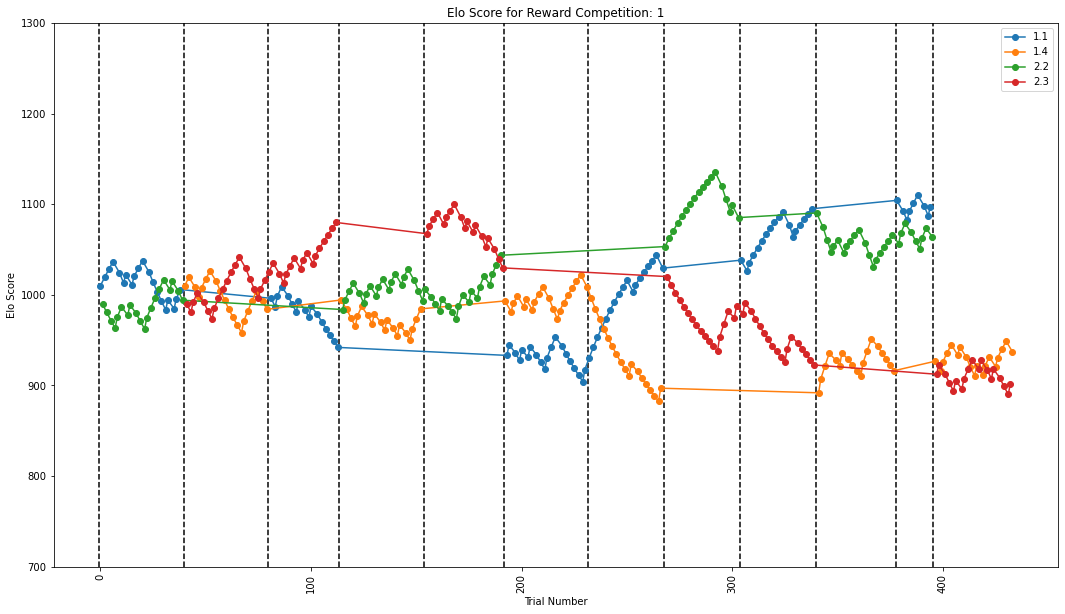

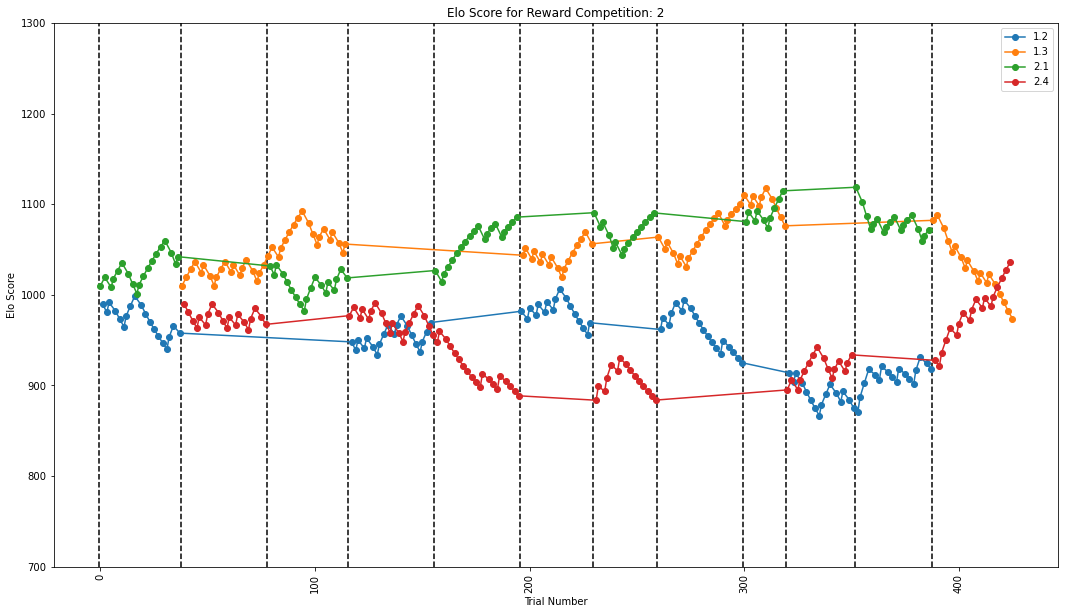

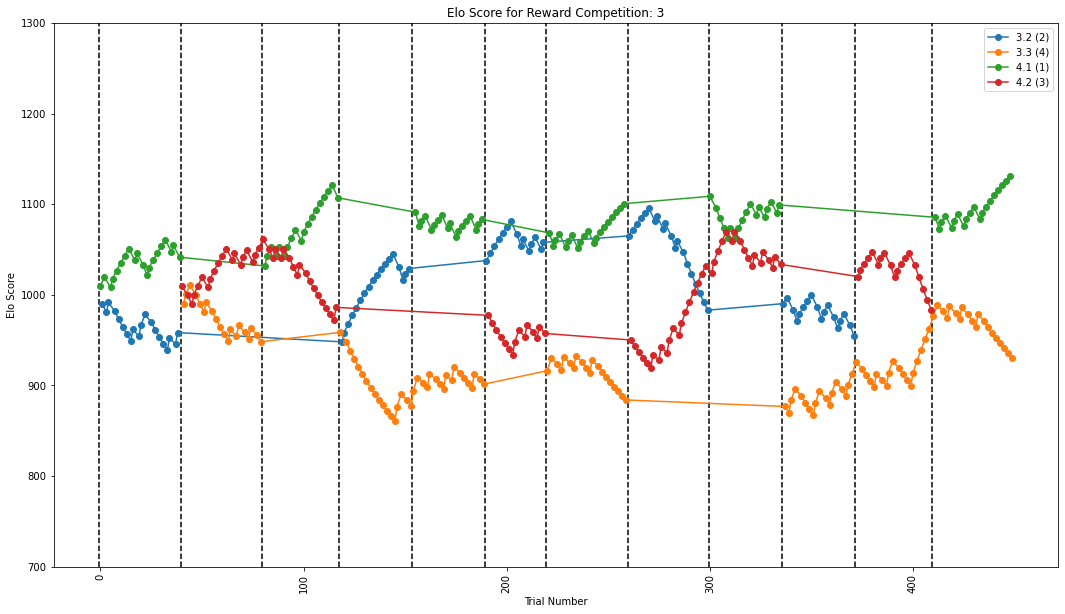

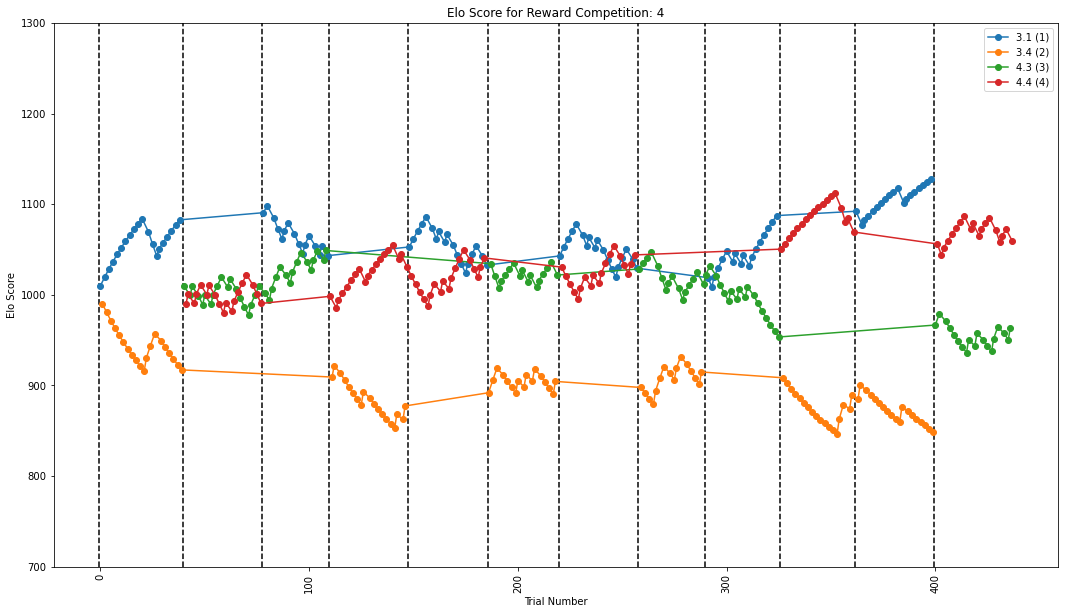

In [93]:
for cage in all_cage_elo_score_df["cage"].unique():
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (18,10)
    per_cage_df = all_cage_elo_score_df[all_cage_elo_score_df["cage"] == cage]
       
    for index in per_cage_df["index"].unique():
        first_session_in_trial = per_cage_df[per_cage_df["index"] == index].iloc[0]["total_trial_number"]
        plt.vlines(x=[first_session_in_trial - 0.5], ymin=700, ymax=1300, colors='black', linestyle='dashed')

    
    
    # Drawing a line for each subject
    for subject in sorted(per_cage_df["subject_id"].unique()):
        # Getting all the rows with the current subject
        subject_df = per_cage_df[per_cage_df["subject_id"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        plt.plot(subject_df["total_trial_number"], subject_df["updated_elo_score"], '-o', label=subject)
    
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Trial Number")
    ax.set_ylabel("Elo Score")
    ax.set_title("Elo Score for {}: {}".format(string.capwords(" ".join(protocol_name.split("_"))), cage))
    # To show the legend
    ax.legend()
    plt.xticks(rotation=90)
    plt.ylim(700, 1300) 
    file_name = "{}_elo_score_{}_date_{}_{}.png".format(protocol_name, cage, earliest_date, latest_date)
    plt.savefig(os.path.join(plot_output_directory, file_name))  
    
    plt.show()

# Saving the Dataframes

In [88]:
elo_score_spreadsheet_output_directory = "./proc/elo_score_spread_sheets/{}_elo_score/cage_{}_date_{}_{}".format(protocol_name, all_cages, earliest_date, latest_date)

In [89]:
elo_score_spreadsheet_output_directory

'./proc/elo_score_spread_sheets/reward_competition_elo_score/cage_1_2_3_4_date_20220519_20220520'

In [90]:
os.makedirs(elo_score_spreadsheet_output_directory, exist_ok=True)

In [91]:
file_name = "{}_elo_score_history_cages_{}_date_{}_{}.csv".format(protocol_name, all_cages, earliest_date, latest_date)
all_cage_elo_score_df.to_csv(os.path.join(elo_score_spreadsheet_output_directory, file_name))

In [92]:
file_name = "{}_final_elo_score_cages_{}_date_{}_{}.csv".format(protocol_name, all_cages, earliest_date, latest_date)
id_to_final_elo_score_df.to_csv(os.path.join(elo_score_spreadsheet_output_directory, file_name))